In [17]:
from numpy.random import normal
from numpy import cos, sin, pi, linspace, array, concatenate, append, array
from random import random, sample, choices

from pandas import DataFrame, read_csv
import geopandas as gpd

from shapely.geometry import MultiPoint

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import rasterio

from numba import njit
from numba.typed import List



#import plotly.express as px

In [99]:
def generateRandomHalo():
    
    r = random()+sample([0,1],1)[0]

    h = random()*20
    k = random()*20

    x = r*cos(linspace(0,2*pi,700))+h
    x = [i+normal()/10 for i in x]
    
    y = r*sin(linspace(0,2*pi,700))+k
    y = [i+normal()/10 for i in y]

    return [x,y]

In [100]:
def generateRandomForest(n,p):
    x = array([])
    y = array([])
    
    for _ in range(n):
        halos = generateRandomHalo()
        x = concatenate((x,halos[0]))
        y = concatenate((y,halos[1]))
        
    p = int(len(x)*p/100)
    
    xs = choices(range(int(min(x)),int(max(x))),k=p)
    ys = choices(range(int(min(y)),int(max(y))),k=p)

    x = concatenate((x,[i+normal() for i in xs]))
    y = concatenate((y,[i+normal() for i in ys]))

    return x,y
    

In [18]:
def dbscanTrees(data, eps, samp):
    
    clustering = DBSCAN(eps =eps, min_samples = samp).fit(data)
    labels = clustering.labels_

    print('Número de troncos: ',len(set(labels)) - (1 if -1 in labels else 0))

    return labels

In [19]:
def inputDBscan(df,x,y):
    return [[i,j] for i,j in zip(df[x],df[y])]

In [82]:
@njit
def mesureTreeHeight(x,y,z,matrix,geoTrans):
    
    h = List()
    
    cx= geoTrans[0]/2 + geoTrans[2]
    cy= geoTrans[4]/2  + geoTrans[-4]
    
    for i,j,k in zip(x,y,z):
        icol = round((i-cx)/geoTrans[0])
        irow = round((j-cy)/geoTrans[4])
        h.append(k-rmatriz[irow,icol])
        
    return h 

In [84]:
def mesureTreeHeight2(x,y,z,matrix,geoTrans):
    
    h = List()
    
    cx= geoTrans[0]/2 + geoTrans[2]
    cy= geoTrans[4]/2  + geoTrans[-4]
    
    for i,j,k in zip(x,y,z):
        icol = round((i-cx)/geoTrans[0])
        irow = round((j-cy)/geoTrans[4])
        h.append(k-rmatriz[irow,icol])
        
    return h 

In [10]:
x,y = generateRandomForest(10,20)

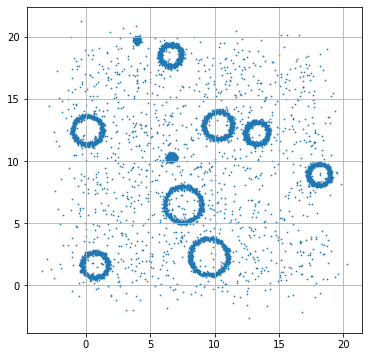

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,s=.5)
plt.grid()
plt.savefig('RandomData.png',dpi=150,bbox_inches='tight')

In [13]:
coords = DataFrame({'x':x,'y':y})

In [14]:
data = [[i,j] for i,j in zip(x,y)]

In [15]:
coords['label'] = dbscanTrees(data,.15, 10)

Número de troncos:  10


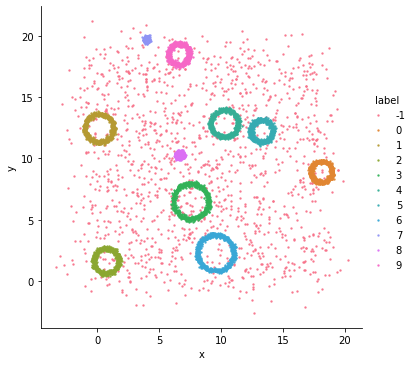

In [16]:
sns.lmplot(x='x',y='y', data=coords, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.savefig('RandomDataClassified.png',dpi=150,bbox_inches='tight')
plt.show()

In [17]:
sr=coords[coords.label!=-1]

In [18]:
gsr=gpd.GeoDataFrame(sr,geometry=gpd.points_from_xy(sr.x,sr.y))

In [19]:
troncos = []
for i in gsr.label.unique():
    
    log = gsr[gsr.label==i]
    pts=[(i,j) for i,j in zip(log.geometry.x,log.geometry.y)]
    
    troncos.append(MultiPoint(pts))

In [20]:
logs=gpd.GeoDataFrame({'id':gsr.label.unique(),'geometry':troncos})

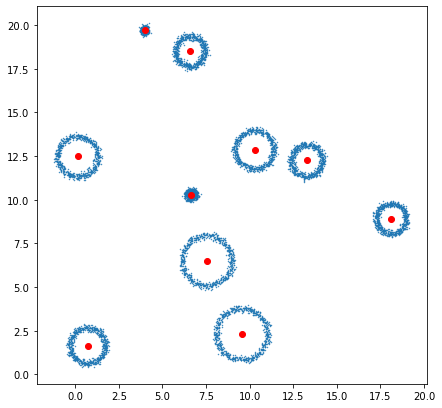

In [21]:
ax=logs.plot(figsize=(7,7),markersize=.2)
logs.centroid.plot(ax=ax,color='red');
plt.savefig('RandomDataClassified_NoNoiseCentroid.png',dpi=150,bbox_inches='tight')

## Caso Real Aereo

In [76]:
df = read_csv('Yuncos_clasArbol.csv')

In [80]:
sub=df[(df.ELEV<555) & (df.ELEV>554)].iloc[:10000000]

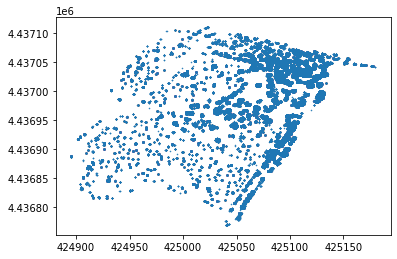

In [81]:
plt.scatter(sub.X,sub.Y,s=.3);

In [70]:
data = inputDBscan(sub, 'X', 'Y')

In [71]:
sub['label'] = dbscanTrees(data, 2, 5)

Número de troncos:  144


In [72]:
snrui = sub[sub.label!=-1]

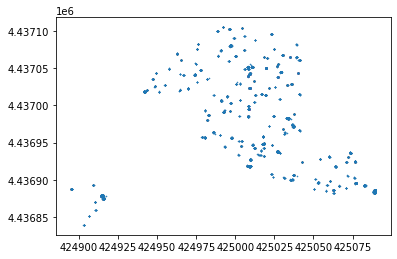

In [73]:
plt.scatter(snrui.X, snrui.Y,s=.3);

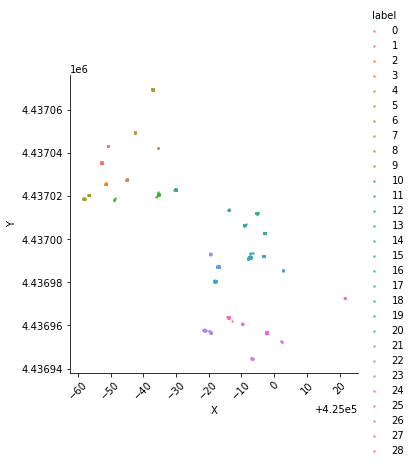

In [67]:
sns.lmplot(x='X',y='Y', data=snrui, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.xticks(rotation=45)
#plt.savefig('Outputs/')
plt.show()

## Caso Real Terrestre

In [978]:
df = read_csv('lidar_mano.csv',usecols=['X','Y','ELEVATION'],
              dtype={'X':float,'Y':float,'ELEVATION':float})

In [979]:
sub=df[(df.ELEVATION<5) & (df.ELEVATION>3)].copy()

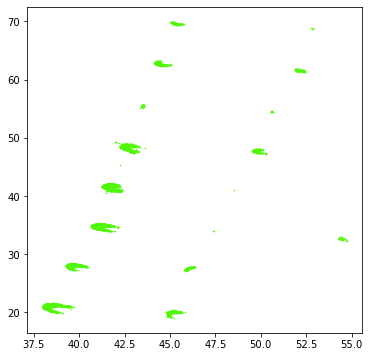

In [980]:
plt.figure(figsize=(6,6), edgecolor='y')
plt.scatter(sub.X,sub.Y,s=.3,c='#50f807');
plt.savefig('Outputs/TerrestrialLidarTree.png',dpi=150,bbox_inches='tight')

In [981]:
data = inputDBscan(sub, 'X', 'Y')

In [982]:
sub['label'] = dbscanTrees(data, 2, 50)

Número de troncos:  12


In [983]:
sub = sub[sub.label!=-1]

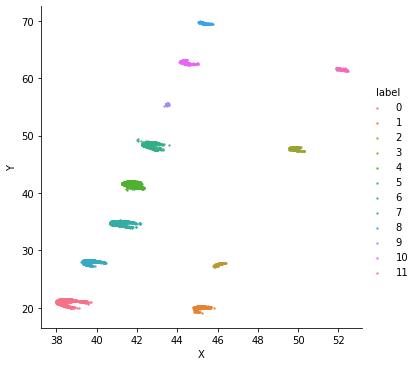

In [984]:
sns.lmplot(x='X',y='Y', data=sub, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.savefig('Outputs/TerrestrialLidarTree_Classified.png',dpi=150,bbox_inches='tight')
plt.show()

In [985]:
sub.label.value_counts()

4     1570
6     1558
5     1322
7     1171
0      827
10     603
2      266
1      247
8      197
3      148
9      112
11      92
Name: label, dtype: int64

In [989]:
circ=sub[sub.label==4]

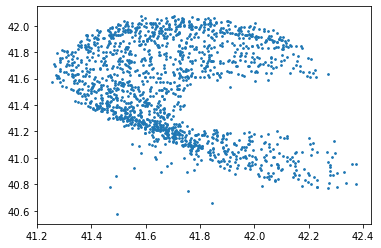

In [994]:
plt.scatter(circ.X,circ.Y,s=3);

## Zona seleccionada

In [2]:
raster= rasterio.open("terreno_Yuncos.tif")

In [3]:
csv=read_csv("Yuncos_arboles_corte.csv",usecols=["X","Y","ELEV"],
            dtype={"x":float,"Y":float,"ELEV":float})

In [4]:
rmatriz=raster.read(1)

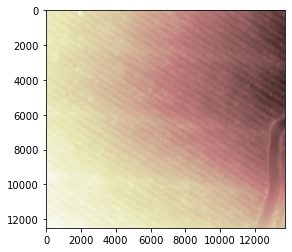

In [7]:
plt.imshow(rmatriz,cmap="pink")

In [5]:
geoTrans = tuple(raster.transform)

In [9]:
geoTrans

(0.007686452161303592,
 0.0,
 424993.82844146295,
 0.0,
 -0.007686452161270179,
 4437011.722209427,
 0.0,
 0.0,
 1.0)

In [7]:
x = List(csv.X)
y = List(csv.Y)
z = List(csv.ELEV)

In [83]:
alturas = mesureTreeHeight(x,y,z,rmatriz,geoTrans)

In [85]:
%timeit mesureTreeHeight(x,y,z,rmatriz,geoTrans)

427 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
%timeit mesureTreeHeight2(x,y,z,rmatriz,geoTrans)

1min 17s ± 3.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
csv['alturas']=list(alturas)

In [78]:
csv.alturas.max()

17.27435274609377

In [31]:
corte=csv[(csv.alturas<1.55) & (csv.alturas>1.45)].copy()

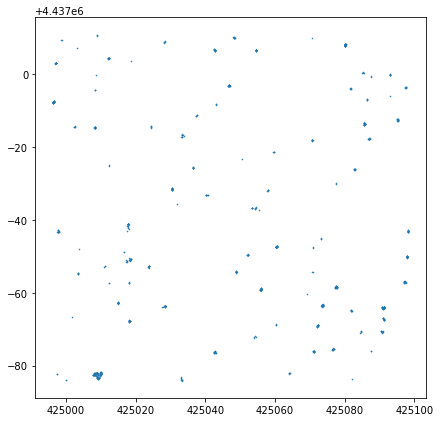

In [32]:
plt.figure(figsize=(7,7))
plt.scatter(corte.X,corte.Y,s=.3)
plt.show()

In [73]:
corte['label'] = dbscanTrees(corte, 1, 5)

Número de troncos:  57


In [67]:
corte.to_csv('output_150.csv',index=False)

In [68]:
sub = corte[corte.label!=-1].copy()
ruid = corte[corte.label==-1].copy()

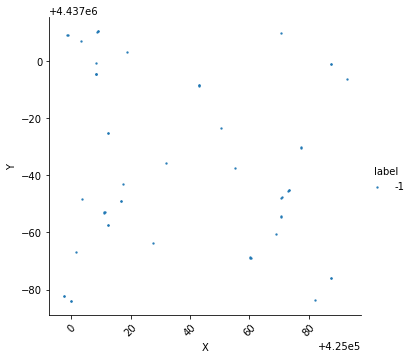

In [69]:
sns.lmplot(x='X',y='Y', data=ruid, hue='label', fit_reg=False, scatter_kws={"s": 2})
plt.xticks(rotation=45)
#plt.savefig('Outputs/')
plt.show()

In [70]:
fig = px.scatter(x=corte.X, y=corte.Y, color=[str(i) for i in corte.label])

In [71]:
fig.write_html("file.html")